# Classification Part 2:
1. Support Vector Machines
2. Decision Trees
3. Ensemble Learning
4. Naive Bayes

Support vector machine (SVM) is a supervised algorithm for classification.


**So what's the MAIN IDEA?** : Find a line / curve (in 2-D) that separates the classes from one another.

https://media.giphy.com/media/U23WekMlGy6cImpMim/giphy.gif

Before we start importing libraries, here's a tip!

Hover over a library to understand what it's used for

Try it for the ones below.

In [1]:
#Import some basic libraries

#Helps to store our graphs inside this .ipynb file!
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt

#this is something new
from scipy import stats 
# use seaborn plotting defaults
import seaborn as sns; sns.set()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


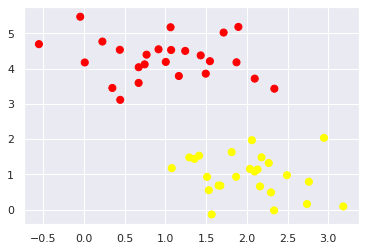

In [2]:

# A simple two class data plot
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');



We can draw a straight line separating the two sets of data, and thereby create a model for classification!
We could draw this line by hand.


But, do you see a problem in this method?

AND WHAT IS THAT?!

Hint : Run the code below.

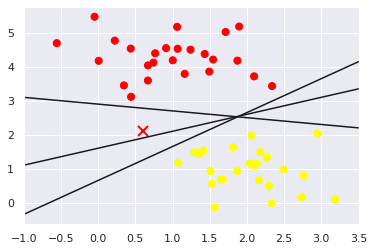

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

Conclusions from the above graph?
< fill here >

## Support Vector Machines: Maximizing the *Margin*

Support vector machines offer one way to improve on this.
The intuition is this: Instead of drawing a zero-width line between the classes, we draw around each line a *margin* of some width, up to the nearest point.
Here is an example:

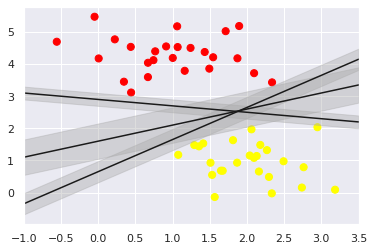

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

In support vector machines, the line that maximizes this margin is the optimal model.
Thus, it is an example of a *maximum margin* estimator.

### Fitting a support vector machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data.
We use a linear kernel and set the ``C`` parameter to a large number (we'll discuss this).

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

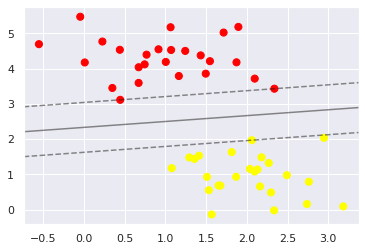

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points.
Notice that a few of the training points just touch the margin: they are indicated by the black circles.
These points are the pivotal elements of this fit.
We call them as *support vectors*, and hence the name Support Vector Machines!
In Scikit-Learn, the identity of these points are stored in the ``support_vectors_`` attribute of the classifier:

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit!
Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

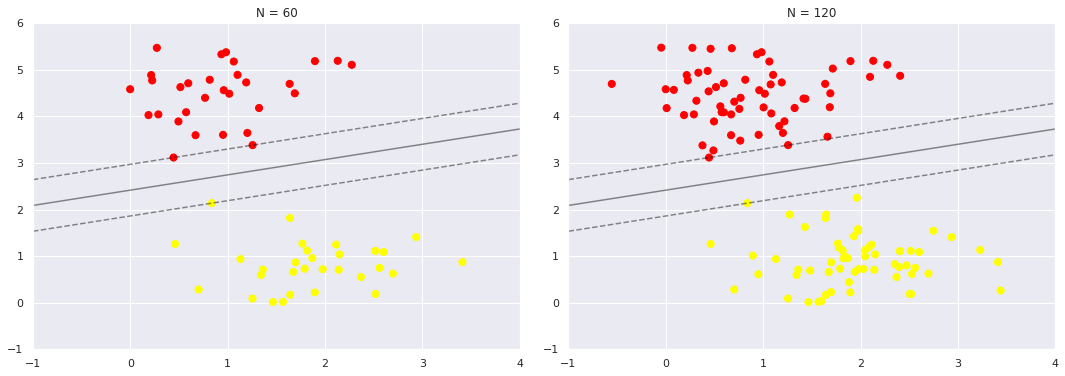

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In the left panel, we see the model and the support vectors for 60 training points.
In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel.
This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

If you are running this notebook live, you can use IPython's interactive widgets to view this feature of the SVM model interactively:

In [10]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget…

### ALERT! Advanced topics that are beyond the scope of this course. Proceed at your own peril! 

### Beyond linear boundaries: Kernel SVM

Where SVM becomes extremely powerful is when it is combined with *kernels*.
We have seen a version of kernels before, in the basis function regressions of Linear Regression.
There we projected our data into higher-dimensional space defined by polynomials and Gaussian basis functions, and thereby were able to fit for nonlinear relationships with a linear classifier.

In SVM models, we can use a version of the same idea.
To motivate the need for kernels, let's look at some data that is not linearly separable:

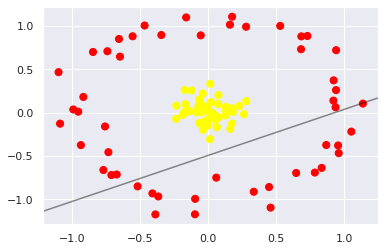

In [11]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

It is clear that no linear discrimination will *ever* be able to separate this data.
But we can draw a lesson from the basis function regressions in Linear Regression, and think about how we might project the data into a higher dimension such that a linear separator *would* be sufficient.
For example, one simple projection we could use would be to compute a *radial basis function* centered on the middle clump:

In [12]:
r = np.exp(-(X ** 2).sum(1))

We can visualize this extra data dimension using a three-dimensional plot—if you are running this notebook live, you will be able to use the sliders to rotate the plot:

In [13]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(-90, 90), value=-90), IntSlider(value=30, descript…

We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, *r*=0.7.

Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results.
In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy to this end is to compute a basis function centered at *every* point in the dataset, and let the SVM algorithm sift through the results.
This type of basis function transformation is known as a *kernel transformation*, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large.
However, because of a neat little procedure known as the [*kernel trick*](https://en.wikipedia.org/wiki/Kernel_trick), a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$-dimensional representation of the kernel projection!
This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the ``kernel`` model hyperparameter:

In [14]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

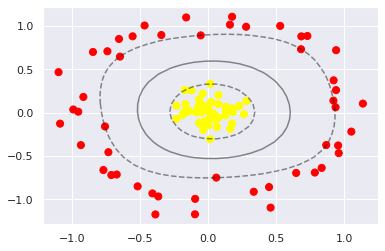

In [15]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.
This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

### Tuning the SVM: Softening Margins

Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists.
But what if your data has some amount of overlap?
For example, you may have data like this:

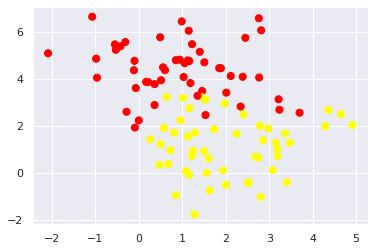

In [16]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit.
The hardness of the margin is controlled by a tuning parameter, most often known as $C$.
For very large $C$, the margin is hard, and points cannot lie in it.
For smaller $C$, the margin is softer, and can grow to encompass some points.

The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, via the softening of the margin:

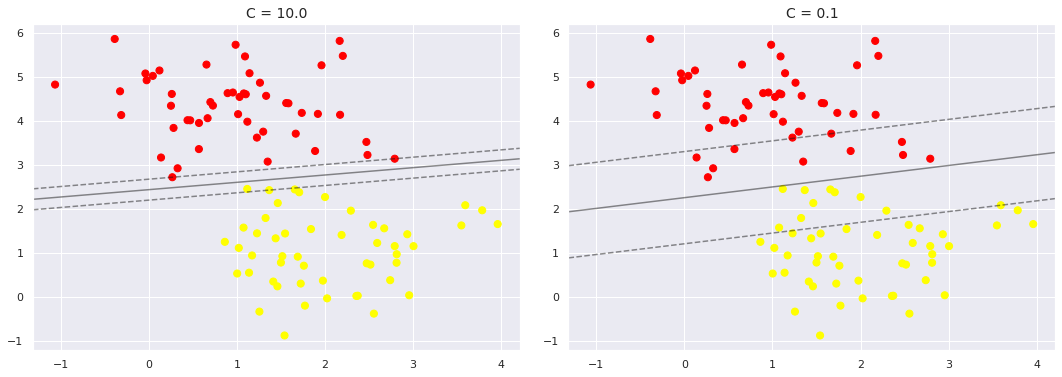

In [17]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar procedure.

## Classification Example: Facial Recognition!

A cool current problem is facial recognition!
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:

In [18]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's plot a few of these faces to see what we're working with:

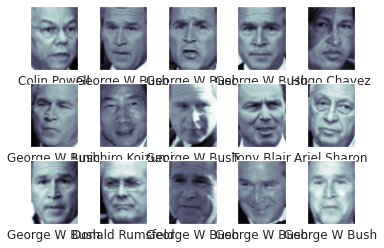

In [19]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Each image contains [62×47] or nearly 3,000 pixels.
We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a principal component analysis to extract 150 fundamental components to feed into our SVM classifier!
We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [23]:
from sklearn.svm import SVC
#from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

For the sake of testing our classifier output, we will split the data into a training and testing set:

In [28]:
import numpy as np
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Finally, we can use a grid search cross-validation to explore combinations of parameters.
Here we will adjust ``C`` (which controls the margin hardness) and ``gamma`` (which controls the size of the radial basis function kernel), and determine the best model:

In [30]:
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 1min 15s, sys: 41.4 s, total: 1min 56s
Wall time: 1min 10s
{'svc__C': 10, 'svc__gamma': 0.001}


The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

Now with this cross-validated model, we can predict the labels for the test data, which the model has not yet seen:

In [31]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Let's take a look at a few of the test images along with their predicted values:

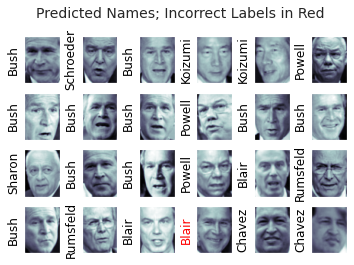

In [32]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Out of this small sample, our optimal estimator mislabeled only a single face (Bush’s
face in the bottom row was mislabeled as Blair).
We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:

In [33]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

         accuracy                           0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



We might also display the confusion matrix between these classes:

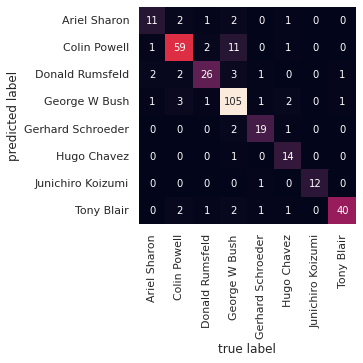

In [34]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

2. Decision Trees
3. Ensemble Learning

#Decision Trees
Uses a tree structure to help break down the dataset into smaller subsets -> prediction. 

There are decision nodes that partition the data and leaf nodes that give the prediction that can be followed by traversing simple IF..AND..AND….THEN logic down the nodes.

The root node partitions the data based on the most influential feature partitioning. 

There are 2 measures for this, Gini Impurity and Entropy.

#1. Entropy
The root node (the first decision node) partitions the data using the feature that provides the most information gain.

Information gain tells us how important a given attribute of the given set of feature vectors.

It is calculated as:

$Information Gain=Entropy(parent)–[Average Entropy(children)]$

Where entropy is a common measure of target class impurity, given as:

$Entropy=\sum_{i} -p_i log_2 (p_i)$

#2. Gini Impurity 
Gini Impurity is another measure of impurity and is calculated as follows:

$Gini=1–\sum_{i}p_i^2$

Gini impurity is computationally faster as it doesn’t require calculating logarithmic functions, though in reality which of the two methods is used rarely makes too much of a difference.




#Let's use the Titanic dataset from Lab 1 to do predictions!

In [35]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/suhasbn/DS310/master/titanic-train.csv', index_col='PassengerId')
print(df.head())

             Survived  Pclass  ... Cabin Embarked
PassengerId                    ...               
1                   0       3  ...   NaN        S
2                   1       1  ...   C85        C
3                   1       3  ...   NaN        S
4                   1       1  ...  C123        S
5                   0       3  ...   NaN        S

[5 rows x 11 columns]


In [36]:
df = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']]

#Convert gender to integer values for easier calculations
gender = pd.get_dummies(df['Sex'],drop_first=True)
df.drop(['Sex'],axis=1,inplace=True)
df.head()

df = pd.concat([df,gender],axis=1)
#df['Sex'] = df['Sex'].map(gender)
#df.head()

In [37]:
df['male']

PassengerId
1      1
2      0
3      0
4      0
5      1
      ..
887    1
888    0
889    0
890    1
891    1
Name: male, Length: 891, dtype: uint8

In [38]:
#Drop rows with missing values as before
df = df.dropna()
X = df.drop('Survived', axis=1)
y = df['Survived']

#preparing the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
model = tree.DecisionTreeClassifier()
model
#How do you think we can prevent overfitting?

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [40]:
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_predict)

0.8100558659217877

In [41]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix

pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted Not Survival', 'Predicted Survival'],
    index=['True Not Survival', 'True Survival']
)

,Predicted Not Survival,Predicted Survival
True Not Survival,96,16
True Survival,18,49


#How do we visualize the decision tree?

In [42]:
!apt install -y graphviz
!pip install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


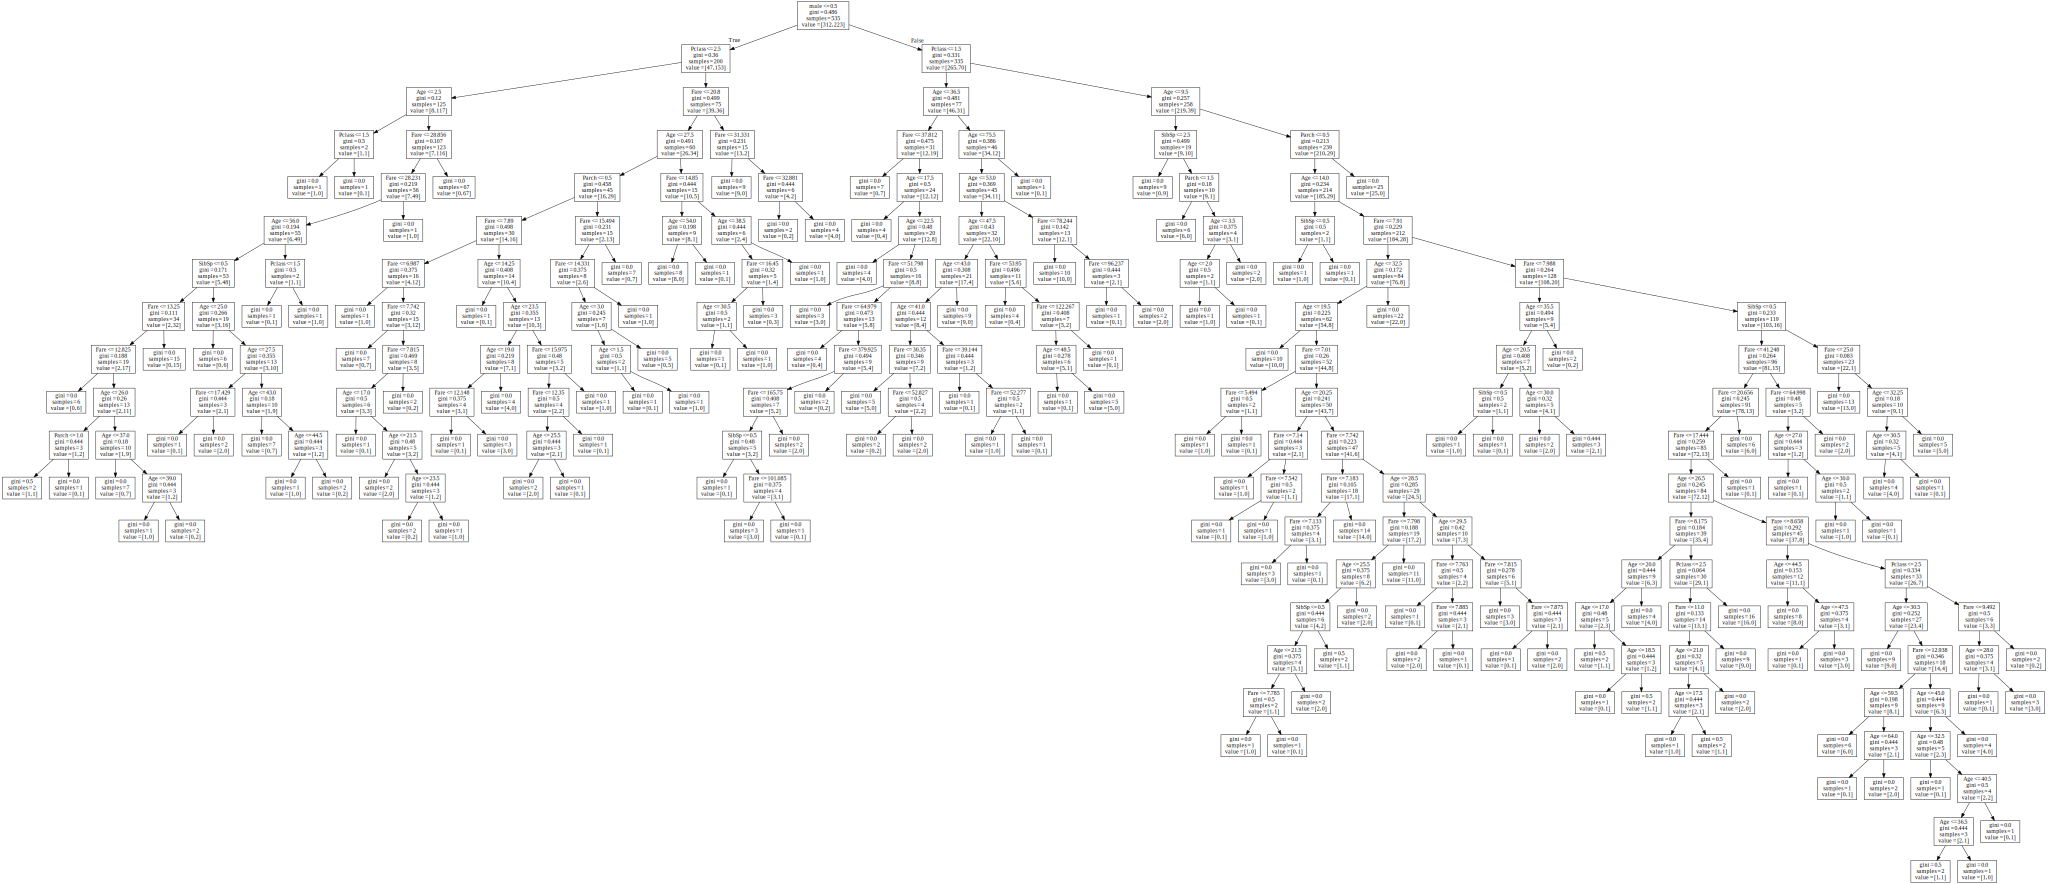

In [43]:
from graphviz import Source
from IPython.display import SVG
graph = Source(tree.export_graphviz(model, out_file=None, feature_names=X.columns))
SVG(graph.pipe(format='svg'))

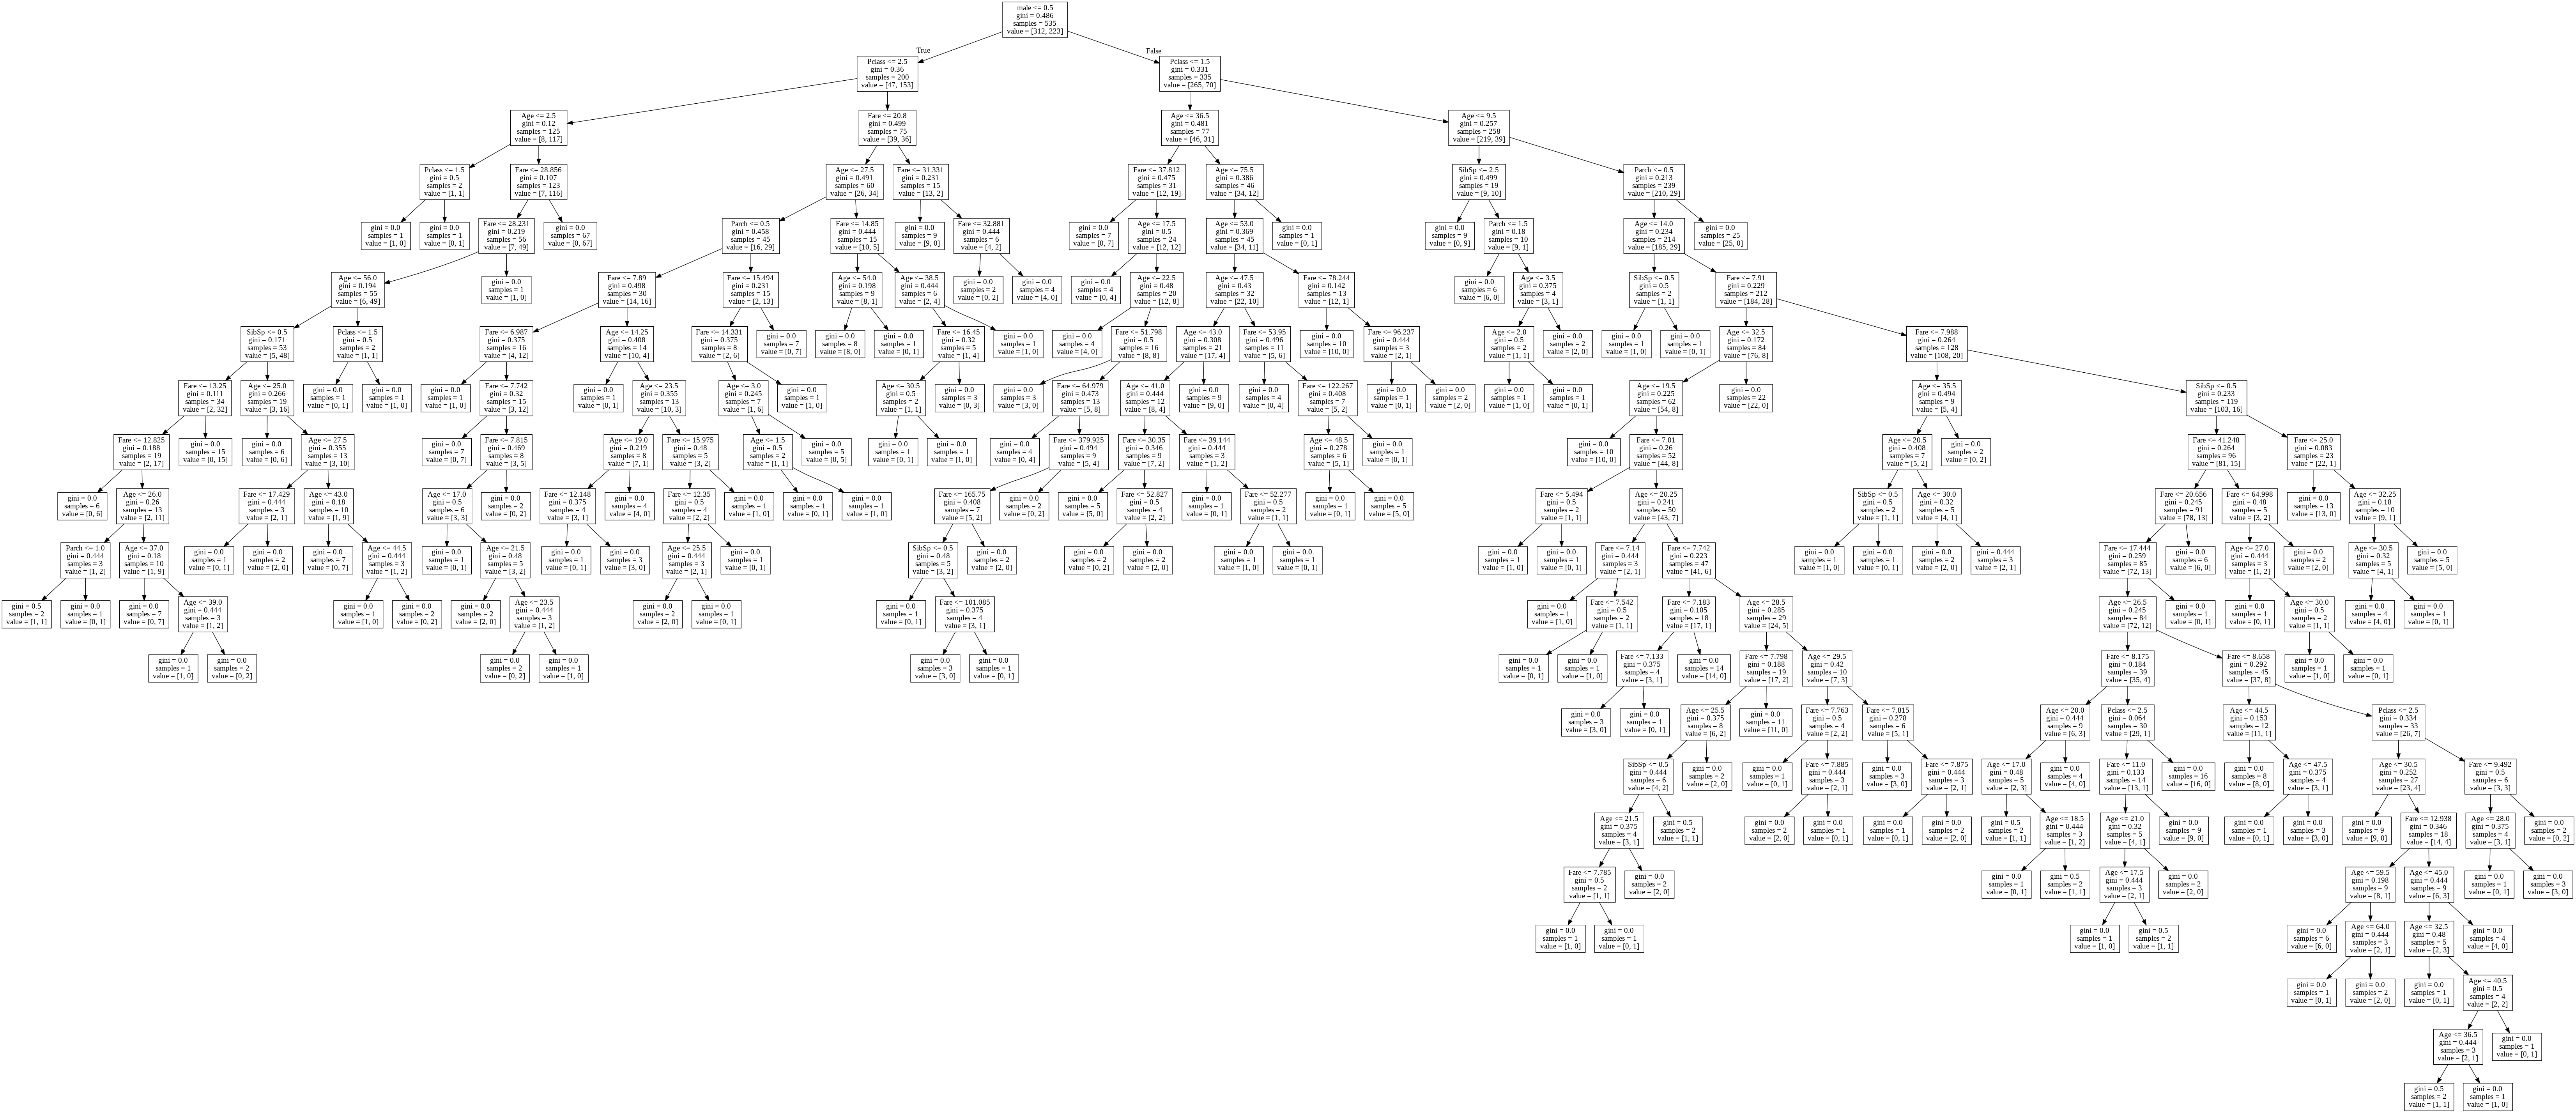

In [44]:
#In case you want to visualize it better

graph = Source(tree.export_graphviz(model, out_file=None, feature_names=X.columns))
png_bytes = graph.pipe(format='png')
with open('dtree_pipe.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

#Ensemble Learning
The idea is to use a combination of two or more models to make better predictions on a dataset.

Let's try doing it with all the models that we have used so far.

In [45]:
#Let's try with the diabetes dataset
import pandas as pd
#read in the dataset
df = pd.read_csv('https://raw.githubusercontent.com/suhasbn/DS310/master/diabetes.csv')
#take a look at the data
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [46]:
#split data into inputs and targets
X = df.drop(columns = ['Outcome'])
y = df['Outcome']
from sklearn.model_selection import train_test_split
#split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [47]:
#Part 1 kNN

import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
#create new a knn model
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
params_knn = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=5)
#fit model to training data
knn_gs.fit(X_train, y_train)

#save best model
knn_best = knn_gs.best_estimator_
#check best n_neigbors value
print(knn_gs.best_params_)

{'n_neighbors': 8}


In [48]:
# Part 2 Random Forest 
from sklearn.ensemble import RandomForestClassifier
#create a new random forest classifier
rf = RandomForestClassifier()
#create a dictionary of all values we want to test for n_estimators
params_rf = {'n_estimators': [50, 100, 200]}
#use gridsearch to test all values for n_estimators
rf_gs = GridSearchCV(rf, params_rf, cv=5)
#fit model to training data
rf_gs.fit(X_train, y_train)

#save best model
rf_best = rf_gs.best_estimator_
#check best n_estimators value
print(rf_gs.best_params_)

{'n_estimators': 100}


In [49]:
# Part 3 Logistic Regression
from sklearn.linear_model import LogisticRegression
#create a new logistic regression model
log_reg = LogisticRegression()
#fit the model to the training data
log_reg.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
#Individually, how do each of our three classifiers work?

#test the three models with the test data and print their accuracy scores
print('kNN: {}'.format(knn_best.score(X_test, y_test)))
print('RF: {}'.format(rf_best.score(X_test, y_test)))
print('LogRegression: {}'.format(log_reg.score(X_test, y_test)))

kNN: 0.7489177489177489
RF: 0.7575757575757576
LogRegression: 0.7748917748917749


# The fun part : Voting!


In [51]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators=[('kNN', knn_best), ('RF', rf_best), ('LogRegression', log_reg)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard') #Here, hard means majority voting - check out the function file on skLearn page for more details

#fit model to training data
ensemble.fit(X_train, y_train)
#test our model on the test data
ensemble.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.7662337662337663

#Lab 4 Assignment (Due Oct. 29th, 2021 11:59 PM EST)
#Q1
1a) Use the Iris dataset from Lab 3 and compare the previous kNN results with Naive Bayes classifier (Refer GaussianNB : https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)

 
1b) Are there any difference in results?


1c) Which do you think should perform better? Justify.

(Make sure to use the same data for both experiments for comparison)





#Q2

a) Create an Ensemble Learning model for the Iris dataset with all (15) combinations ( taken from the following : 
1) Decision Trees
2) Naive Bayesian
3) Support Vector Machines
4) Random Forest

2b) What combination works the best? Why do you think so?